In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
import re
import numpy as np
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense, Conv2DTranspose, Reshape, Multiply, \
    Embedding, Conv2D, Concatenate, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf
from datetime import datetime

In [2]:
keras.backend.clear_session()
z_dim = 100
num_class = 4
img_shape = (64, 64, 3)
batch_size = 9
epochs = 100
sample_interval = 10
path = '/home/neto/Documents/Linnaeus/train/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  image_size=(64, 64),
  batch_size=batch_size)

Found 4800 files belonging to 4 classes.


2021-11-07 17:15:13.523273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 17:15:13.527028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 17:15:13.527247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 17:15:13.527628: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [5]:
def build_generator(z_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(256, 3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, 3, activation='tanh', padding='same'))

    return model

In [6]:
def build_discriminator(img_shape):
    model = Sequential(name="discriminator")
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample 
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [7]:
def build_gan(gen, disc):
    disc.trainable = False
    model = Sequential(name="GAN")
    model.add(gen)
    model.add(disc)
    return model

In [17]:
def sample_images(image_grid_rows=2, image_grid_columns=2):
    
    class_names = train_ds.class_names

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            img = gen_imgs[cnt]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            cnt += 1

In [27]:
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    # returned the smoothed labels
    return labels


accuracies = []
losses = []
def train(epochs, batch_size, sample_interval, dataset):
#     (X_train, y_train) = img, labels

    bat_per_epo = len(dataset) # int(X_train.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    real = smooth_labels(np.ones((batch_size, 1)))
    fake = smooth_labels(np.zeros((batch_size, 1)))

    for epoch in range(epochs):
        g_loss = 0
        d_loss = []
        for j in range(bat_per_epo):
#             idx = np.random.randint(0, X_train.shape[0], batch_size)
            normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
            imgs, labels = next(iter(normalized_ds))
#             imgs, labels = X_train[idx], y_train[idx]

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict(z)

            # Train the Discriminator
            d_loss_real = discriminator.train_on_batch(imgs, real)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Generate a batch of noise vectors
            z = np.random.normal(0, 1, (batch_size, z_dim))

            # Get a batch of random labels
            labels = np.random.randint(0, num_class, batch_size).reshape(-1, 1)

            # Train the Generator
            g_loss = cgan.train_on_batch(z, real)
            
        if (epoch + 1) % sample_interval == 0:
            # Output training progress
            print('>%d, %d/%d, [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch + 1, j + 1, bat_per_epo, d_loss[0], 100 * d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [10]:
generator = build_generator(z_dim)
generator.summary()

discriminator = build_discriminator(img_shape)
discriminator.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=4e-4),
                      metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

cgan = build_gan(generator, discriminator)
cgan.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=1e-4))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         590080    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0

2021-11-07 17:15:14.171825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-07 17:15:16.095038: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


>10, 534/534, [D loss: 0.203903, acc.: 100.00%] [G loss: 2.866058]
>20, 534/534, [D loss: 0.279046, acc.: 94.44%] [G loss: 4.146457]
>30, 534/534, [D loss: 0.207963, acc.: 100.00%] [G loss: 3.830920]
>40, 534/534, [D loss: 0.202093, acc.: 100.00%] [G loss: 2.814504]
>50, 534/534, [D loss: 0.203795, acc.: 100.00%] [G loss: 3.007811]
>60, 534/534, [D loss: 0.206027, acc.: 100.00%] [G loss: 2.590449]
>70, 534/534, [D loss: 0.202946, acc.: 100.00%] [G loss: 2.972175]
>80, 534/534, [D loss: 0.207541, acc.: 100.00%] [G loss: 2.248796]
>90, 534/534, [D loss: 0.302589, acc.: 94.44%] [G loss: 2.217929]
>100, 534/534, [D loss: 0.202789, acc.: 100.00%] [G loss: 2.777473]


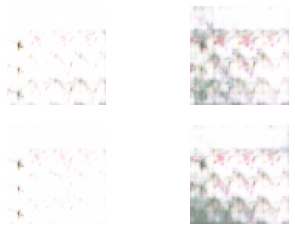

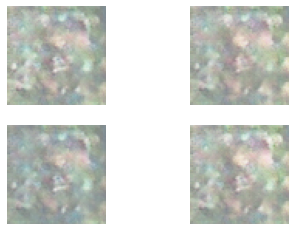

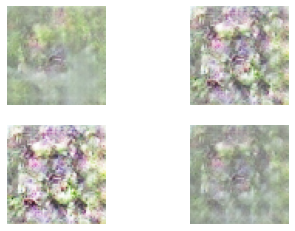

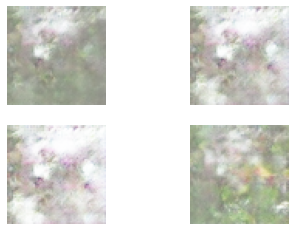

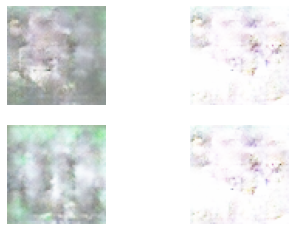

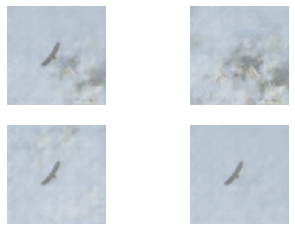

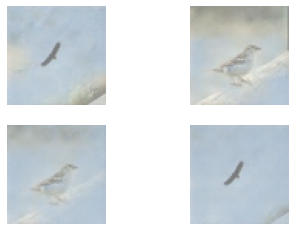

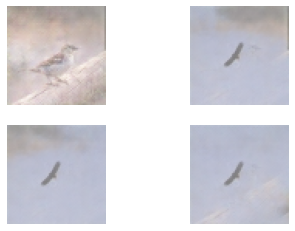

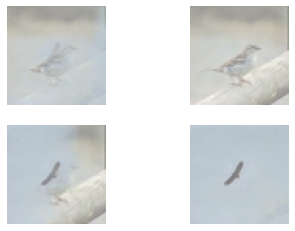

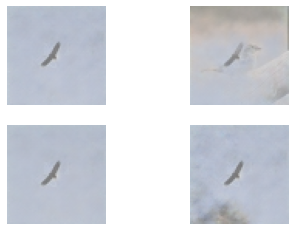

In [11]:
train(epochs, batch_size, sample_interval, train_ds)

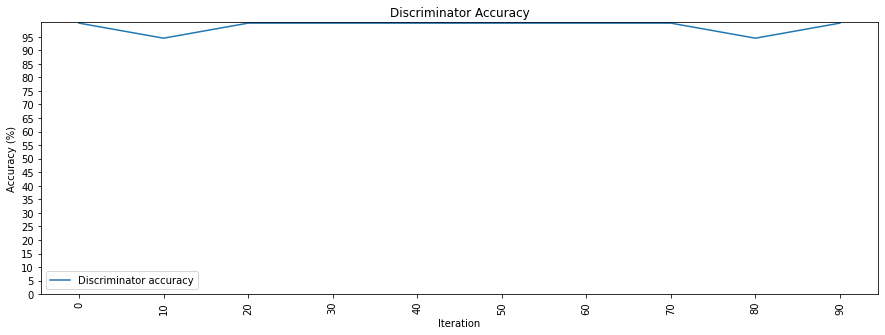

In [12]:
epoch = [x for x in range(0, epochs, 10)]

plt.figure(figsize=(15, 5))
plt.plot(epoch, accuracies, label="Discriminator accuracy")

plt.xticks(epoch, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

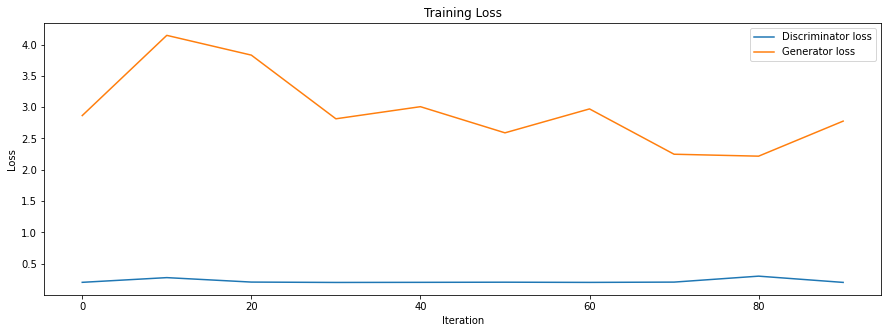

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(epoch, [x[0] for x in losses], label="Discriminator loss")
plt.plot(epoch, [x[1] for x in losses], label="Generator loss")

# plt.xticks(self.epoch, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

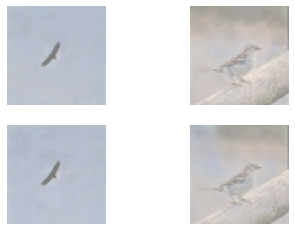

In [19]:
sample_images()

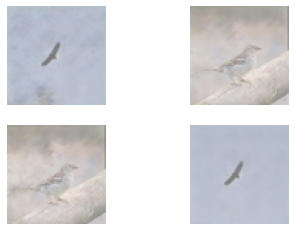

In [18]:
sample_images()

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
imgs, labels = next(iter(normalized_ds))

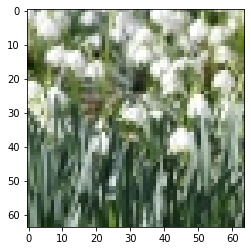

In [26]:
plt.imshow(imgs[0])

In [29]:
keras.backend.clear_session()
generator = build_generator(z_dim)

discriminator = build_discriminator(img_shape)
discriminator.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=4e-4),
                      metrics=['accuracy'])
discriminator.trainable = False

cgan = build_gan(generator, discriminator)
cgan.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=1e-4))

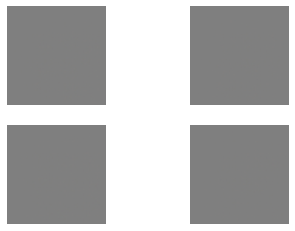

In [30]:
sample_images()

>10, 534/534, [D loss: 0.318768, acc.: 50.00%] [G loss: 1.883205]
>20, 534/534, [D loss: 0.305327, acc.: 50.00%] [G loss: 1.791305]
>30, 534/534, [D loss: 0.307673, acc.: 50.00%] [G loss: 1.926535]
>40, 534/534, [D loss: 0.315785, acc.: 50.00%] [G loss: 1.879755]
>50, 534/534, [D loss: 0.305032, acc.: 50.00%] [G loss: 1.735878]
>60, 534/534, [D loss: 0.362372, acc.: 50.00%] [G loss: 2.724385]
>70, 534/534, [D loss: 0.306055, acc.: 50.00%] [G loss: 2.078895]
>80, 534/534, [D loss: 0.304192, acc.: 50.00%] [G loss: 2.318179]
>90, 534/534, [D loss: 0.306134, acc.: 50.00%] [G loss: 1.973256]
>100, 534/534, [D loss: 0.310340, acc.: 50.00%] [G loss: 1.980388]


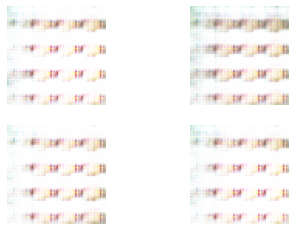

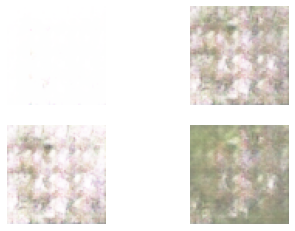

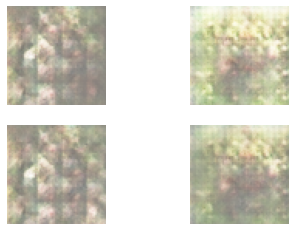

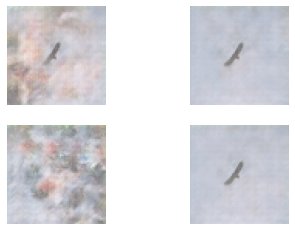

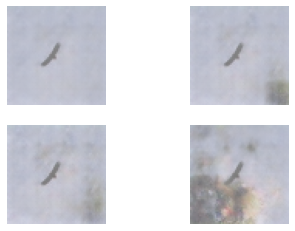

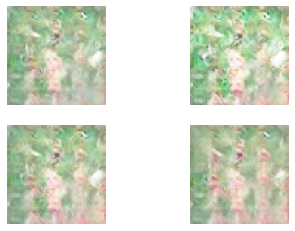

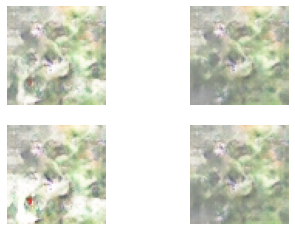

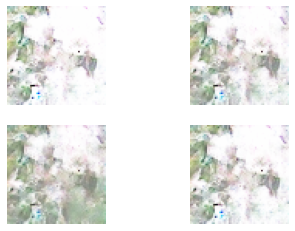

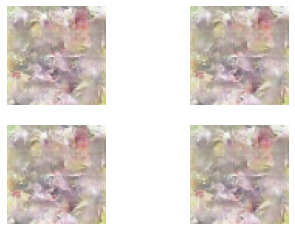

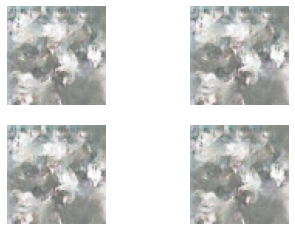

In [31]:
train(epochs, batch_size, sample_interval, train_ds)